In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sqlite3 import Error
import pylab as p
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sn
import numpy as np
from ipywidgets import interact, widgets

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [2]:
conn = create_connection("project.db")

# Import data to be used for analysis
sql_statement = """
        SELECT 
        Year,
        TeamName, 
        Date, Odds
        FROM FiveThirtyEight
        INNER JOIN Season ON FiveThirtyEight.SeasonID = Season.SeasonID
        INNER JOIN Team ON FiveThirtyEight.TeamID = Team.TeamID
        INNER JOIN DataType ON FiveThirtyEight.DataTypeID = DataType.DataTypeID
        ORDER BY Year, TeamName, Date ASC
        ;"""
df_538 = pd.read_sql_query(sql_statement, conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})

sql_statement = """
        SELECT 
        Year,
        TeamName, 
        Date, Odds
        FROM NormalizedBetting
        INNER JOIN Season ON NormalizedBetting.SeasonID = Season.SeasonID
        INNER JOIN Team ON NormalizedBetting.TeamID = Team.TeamID
        INNER JOIN DataType ON NormalizedBetting.DataTypeID = DataType.DataTypeID
        ORDER BY Year, TeamName, Date ASC
        ;"""
df_bet = pd.read_sql_query(sql_statement, conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})

sql_statement = """
        SELECT 
        Year,
        TeamName, 
        Date, MoneyLine
        FROM MoneyLineBetting
        INNER JOIN Season ON MoneyLineBetting.SeasonID = Season.SeasonID
        INNER JOIN Team ON MoneyLineBetting.TeamID = Team.TeamID
        INNER JOIN DataType ON MoneyLineBetting.DataTypeID = DataType.DataTypeID
        ORDER BY Year, TeamName, Date ASC
        ;"""
df_betML = pd.read_sql_query(sql_statement, conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})

sql_statement = """
        SELECT 
        Year,
        TeamName, 
        Date, Rank, Odds
        FROM PowerRanking
        INNER JOIN Season ON PowerRanking.SeasonID = Season.SeasonID
        INNER JOIN Team ON PowerRanking.TeamID = Team.TeamID
        INNER JOIN DataType ON PowerRanking.DataTypeID = DataType.DataTypeID
        ORDER BY Year, TeamName, Date ASC
        ;"""
df_PR = pd.read_sql_query(sql_statement, conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})

sql_statement = """
        SELECT 
        Year,
        TeamName
        FROM Season
        INNER JOIN Team ON Season.ChampionID = Team.TeamID
        ORDER BY Year ASC
        ;"""
df_champs = pd.read_sql_query(sql_statement, conn)

sql_statement = """
        SELECT 
        TeamName, 
        Date,
        Payout, 
        BetOdds, FiveThirtyEightOdds, RankOdds
        FROM BetSamples
        INNER JOIN Team ON BetSamples.TeamID = Team.TeamID
        INNER JOIN DataType ON BetSamples.DataTypeID = DataType.DataTypeID
        ORDER BY Date, TeamName ASC
        ;"""
df_betSamples = pd.read_sql_query(sql_statement, conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})

# Import raw data to show schema
df_Team = pd.read_sql_query("SELECT * FROM Team;", conn)
df_Season = pd.read_sql_query("SELECT * FROM Season;", conn)
df_DataType = pd.read_sql_query("SELECT * FROM DataType;", conn)
df_FiveThirtyEight = pd.read_sql_query("SELECT * FROM FiveThirtyEight;", conn)
df_NormalizedBetting = pd.read_sql_query("SELECT * FROM NormalizedBetting;", conn)
df_MoneyLineBetting = pd.read_sql_query("SELECT * FROM MoneyLineBetting;", conn)
df_PowerRanking = pd.read_sql_query("SELECT * FROM PowerRanking;", conn)
df_BetSamples = pd.read_sql_query("SELECT * FROM BetSamples;", conn)

conn.close()

# Motivation Behind Project (WHY)

The objective of our project is to determine the best way of predicting an event’s occurrence, where betting markets, statistical models, and expert opinions are available. Best will be defined as a combination of how quickly a prediction converges on the correct answer and how accurate that prediction is over time.

The scope of our project will be the National Basketball Association (NBA). We will begin with the NBA because of accessibility to historical data and its popularity in the analytics community. 

Within the NBA, the most popular event for betting markets is the Championship. Predictions of who will win the Championship begin in preseason and continue to change based on activity throughout the season until it converges on the winner at the end of the postseason. 

The core predictions we analyze will come from expert power rankings, betting markets, and FiveThirtyEight’s model. 

To answer the question of which predictor is best, we...
- Assessed which predictors trail or lead the others
- Determined if there are predictable patterns specific to a predictor

Also, using all of the predictors, we generated a model to predict payout.

## Database Schema

#### Review of Database we created (no PowerRank -> Odds)

In [3]:
print('\nTeam Table')
display(df_Team)
print('\nSeason Table')
display(df_Season)
print('\nDataType Table')
display(df_DataType)
print('\nFiveThirtyEight Table')
display(df_FiveThirtyEight.head())
print('\nNormalizedBetting Table')
display(df_NormalizedBetting.head())
print('\nMoneyLine Table')
display(df_MoneyLineBetting.head())
print('\nPowerRanking Table')
display(df_PowerRanking.head())
print('\nBetSamples Table')
display(df_BetSamples.head())


Team Table


,TeamID,TeamName
0,1,Bucks
1,2,Timberwolves
2,3,Heat
3,4,Wizards
4,5,Hawks
5,6,Celtics
6,7,Pistons
7,8,Nuggets
8,9,Knicks
9,10,Mavericks



Season Table


,SeasonID,Year,ChampionID
0,1,2019,14
1,2,2018,18
2,3,2017,18
3,4,2016,19
4,5,2015,18
5,6,2014,30
6,7,2013,3
7,8,2012,3
8,9,2011,10
9,10,2010,21



DataType Table


,DataTypeID,DataType
0,1,FiveThirtyEight
1,2,NormalizedBetting
2,3,MoneyLineBetting
3,4,PowerRanking
4,5,BetSamples



FiveThirtyEight Table


,DataID,DataTypeID,SeasonID,TeamID,Date,Odds
0,5,1,1,1,2019-06-13,0.0
1,6,1,1,2,2019-06-13,0.0
2,7,1,1,3,2019-06-13,0.0
3,8,1,1,4,2019-06-13,0.0
4,9,1,1,5,2019-06-13,0.0



NormalizedBetting Table


,DataID,DataTypeID,SeasonID,TeamID,Date,Odds
0,1,2,1,14,2018-06-13,0.011925
1,2,2,1,18,2018-06-13,0.355111
2,3,2,1,1,2018-06-13,0.009291
3,4,2,1,12,2018-06-13,0.007911
4,5,2,1,20,2018-06-13,0.168210



MoneyLine Table


,DataID,DataTypeID,SeasonID,TeamID,Date,MoneyLine
0,1,3,1,14,2018-06-13,6600.0
1,2,3,1,18,2018-06-13,125.0
2,3,3,1,1,2018-06-13,8500.0
3,4,3,1,12,2018-06-13,10000.0
4,5,3,1,20,2018-06-13,375.0



PowerRanking Table


,DataID,DataTypeID,SeasonID,TeamID,Date,Rank,Odds
0,1,4,15,28,2005-03-14,1,0.2866
1,2,4,15,3,2005-03-14,2,0.2136
2,3,4,15,30,2005-03-14,3,0.1552
3,4,4,15,31,2005-03-14,4,0.1105
4,5,4,15,7,2005-03-14,5,0.0775



BetSamples Table


,DataID,DataTypeID,TeamID,Date,Payout,BetOdds,FiveThirtyEightOdds,RankOdds
0,1,5,22,2015-10-28,-100.0,0.000871,0.0000,0.0000
1,2,5,1,2015-10-28,-100.0,0.012637,0.0018,0.0000
2,3,5,15,2015-10-28,-100.0,0.051293,0.0315,0.0000
3,4,5,19,2015-10-28,280.0,0.229467,0.2506,0.2136
4,5,5,6,2015-10-28,-100.0,0.005590,0.0309,0.0000


## SQL imports and usable data after joins

In [61]:
print('\nFiveThirtyEight Table')
display(df_538.head())
print('\nNormalizedBetting Table')
display(df_bet.head())
print('\nMoneyLine Table')
display(df_betML.head())
print('\nPowerRanking Table')
display(df_PR.head())
print('\nChampions Table')
display(df_champs.head())
print('\nBetSamples Table')
display(df_betSamples.head())


FiveThirtyEight Table


,Year,TeamName,Date,Odds
0,2016,76ers,2015-10-27,0.0
1,2016,76ers,2015-10-28,0.0
2,2016,76ers,2015-10-29,0.0
3,2016,76ers,2015-10-30,0.0
4,2016,76ers,2015-10-31,0.0



NormalizedBetting Table


,Year,TeamName,Date,Odds
0,2016,76ers,2015-06-17,0.003185
1,2016,76ers,2015-08-01,0.002082
2,2016,76ers,2015-10-27,0.000871
3,2016,76ers,2015-12-01,0.000315
4,2016,76ers,2016-01-01,0.000080



MoneyLine Table


,Year,TeamName,Date,MoneyLine
0,2016,76ers,2015-06-17,25000.0
1,2016,76ers,2015-08-01,40000.0
2,2016,76ers,2015-10-27,100000.0
3,2016,76ers,2015-12-01,250000.0
4,2016,76ers,2016-01-01,999999.0



PowerRanking Table


,DataID,DataTypeID,SeasonID,TeamID,Date,Rank,Odds,Winner
0,1,4,15,28,2005-03-14,1,0.2866,False
1,2,4,15,3,2005-03-14,2,0.2136,False
2,3,4,15,30,2005-03-14,3,0.1552,True
3,4,4,15,31,2005-03-14,4,0.1105,False
4,5,4,15,7,2005-03-14,5,0.0775,False



Champions Table


,Year,TeamName
0,2005,Spurs
1,2006,Heat
2,2007,Spurs
3,2008,Celtics
4,2009,Lakers



BetSamples Table


,TeamName,Date,Payout,BetOdds,FiveThirtyEightOdds,RankOdds
0,76ers,2015-10-28,-100.0,0.000871,0.0000,0.0000
1,Bucks,2015-10-28,-100.0,0.012637,0.0018,0.0000
2,Bulls,2015-10-28,-100.0,0.051293,0.0315,0.0000
3,Cavaliers,2015-10-28,280.0,0.229467,0.2506,0.2136
4,Celtics,2015-10-28,-100.0,0.005590,0.0309,0.0000


# Analysis Details (HOW)

## Problems with Power Ranking Data (Brendan, Evan)

In [5]:
teamFrames = [df_bet.TeamName, df_538.TeamName, df_PR.TeamName]
teams = pd.concat(teamFrames).unique()

@interact(team = teams, year = ['2016','2017','2018','2019'])
def plotYear(team, year):
    ii = df_champs[df_champs.Year == int(year)].index[0]
    
    df_team_538 = df_538[(df_538.Year == int(year)) & (df_538.TeamName == team)]
    df_team_bet = df_bet[(df_bet.Year == int(year)) & (df_bet.TeamName == team)]    
    df_team_PR = df_PR[(df_PR.Year == int(year)) & (df_PR.TeamName == team)]
    
    ax = df_team_bet.sort_values('Date').plot(x="Date", y="Odds", title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
    df_team_538.sort_values('Date').plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
    try:
        df_team_PR.sort_values('Date').plot(x="Date", y="Rank", ax=ax, secondary_y = True, mark_right = False, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
        ax.right_ax.set_ylabel('Rank')
        ax.right_ax.set_ylim(10, 0.75)
        ax.right_ax.legend(['Power Rank'], bbox_to_anchor=(1.05,0.8), loc='upper left')
    except:
        print('The '+team+' were never ranked throughout the '+str(int(year)-1)+'-'+year+' season.')
    ax.set_ylabel('Odds')
    ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')

interactive(children=(Dropdown(description='team', options=('76ers', 'Bucks', 'Bulls', 'Cavaliers', 'Celtics',…

In [7]:
teamFrames = [df_betSamples.TeamName]
teams = pd.concat(teamFrames).unique()
@interact(team = teams)
def plotPayout(team):
    df_champion_betSamples = df_betSamples[(df_betSamples.TeamName == team)].sort_values('Date')
    
    ax = df_champion_betSamples.plot(x="Date", y=['Payout'])
    df_champion_betSamples.plot(x="Date",y=['BetOdds','FiveThirtyEightOdds',], ax=ax, secondary_y = True, mark_right = True, title="2015-2019 " + team)
    ax.right_ax.set_ylabel('Odds')
    ax.right_ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.1,1), loc='upper left')
    ax.set_ylabel('Payout')
    ax.legend(['Bet Payout'], bbox_to_anchor=(1.1,0.8), loc='upper left')

interactive(children=(Dropdown(description='team', options=('76ers', 'Bucks', 'Bulls', 'Cavaliers', 'Celtics',…

## Logistic Regression to Convert Rank -> Odds (Brendan) 
Because the original power ranking values were on a scale of 1-10, it was difficult to compare the predictive accuracy of the power rankings compared to the betting odds and the FiveThirtyEight model odds. Therefore, we wanted to convert the power rankings to a probality of winning the championship. We did this by collecting power ranking data from as far backas 2005, then we divided the data into a training set (before 2016) and a test set (2016-2019). We then determined the probablity of winning the championship given they had a certain rank by dividing the total amount of times a specific ranking was given by the total number of times the team with that ranking ended up winning the championship. Next we did linear discriminant analysis in order to get odds that were more generalizable, since the original\odds were likely overfit to the training data. 

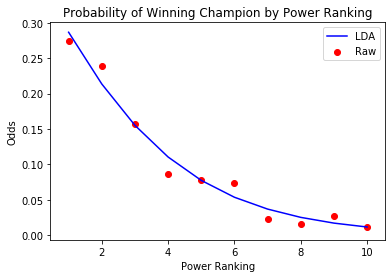

In [65]:
# Logistic regression to get odds for Power Rankings 
from sklearn.linear_model import LogisticRegression
# Create a binary response variable indicating whether a team wins the 
# Championship at the end of the year for each week
df_PR = pd.read_sql_query("Select * From PowerRanking", conn)
df_Season = pd.read_sql_query("Select * From Season", conn)
win_or_lose = []
for i, row in df_PR.iterrows():
    is_champ = False 
    for j, season in df_Season.iterrows():
        if row['SeasonID']==season['SeasonID'] and int(row['TeamID'])==season['ChampionID']:
            is_champ = True
    if is_champ: 
        win_or_lose.append(True)
    else:
        win_or_lose.append(False)

df_PR['Winner'] = win_or_lose
# Will use data prior to 2016 to create model 
X_train = df_PR[df_PR['SeasonID'] > 4][['Rank']]
y_train = df_PR[df_PR['SeasonID'] > 4]['Winner']
X_test = df_PR[df_PR['SeasonID'] <= 4][['Rank']]
y_test = df_PR[df_PR['SeasonID'] <= 4]['Winner']

model = LogisticRegression()
model.fit(X_train,y_train)
probs = model.predict_proba(X_test)
odds = probs[:,1]

odds = list(set(odds))
odds.sort(reverse=True)
        
reg_odds = []
for rank in range(1,11):
    total = 0
    champs = 0
    for i, row in df_PR[df_PR.SeasonID>4].iterrows():
        if row['Rank'] == rank:
            total += 1
            for k, row1 in df_Season.iterrows():        
                if row['SeasonID'] == row1['SeasonID'] and int(row['TeamID']) == row1['ChampionID']:
                    champs += 1
    reg_odds.append(champs/total)  

odds_col = df_PR['Odds'].unique()
plt.plot(y,odds_col,c ='b',label = 'LDA')
plt.scatter(y,reg_odds,c='r',label = 'Raw')
plt.title('Probability of Winning Champion by Power Ranking')
plt.xlabel('Power Ranking')
plt.ylabel('Odds')
plt.legend()
plt.show()

In [68]:
#Resetting PowerRanking Table
sql_statement = """
        SELECT 
        Year,
        TeamName, 
        Date, Rank, Odds
        FROM PowerRanking
        INNER JOIN Season ON PowerRanking.SeasonID = Season.SeasonID
        INNER JOIN Team ON PowerRanking.TeamID = Team.TeamID
        INNER JOIN DataType ON PowerRanking.DataTypeID = DataType.DataTypeID
        ORDER BY Year, TeamName, Date ASC
        ;"""
df_PR = pd.read_sql_query(sql_statement, conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})

In [74]:
df_bets = pd.read_sql_query("select * from betsamples", conn, parse_dates={'Date': {'format': '%Y-%m-%d'}})
display(df_bets)

,DataID,DataTypeID,TeamID,Date,Payout,BetOdds,FiveThirtyEightOdds,RankOdds
0,1,5,22,2015-10-28,-100.0,0.000871,0.0000,0.0000
1,2,5,1,2015-10-28,-100.0,0.012637,0.0018,0.0000
2,3,5,15,2015-10-28,-100.0,0.051293,0.0315,0.0000
3,4,5,19,2015-10-28,280.0,0.229467,0.2506,0.2136
4,5,5,6,2015-10-28,-100.0,0.005590,0.0309,0.0000
...,...,...,...,...,...,...,...,...
26515,26516,5,13,2019-06-13,-100.0,0.000000,0.0000,0.0000
26516,26517,5,2,2019-06-13,-100.0,0.000000,0.0000,0.0000
26517,26518,5,12,2019-06-13,-100.0,0.000000,0.0000,0.0253
26518,26519,5,18,2019-06-13,-100.0,0.706582,0.0000,0.2136


## Plots with All Data Overlaid - Including Rank-Odds (Brendan)

In [75]:

teamFrames = [df_bet.TeamName, df_538.TeamName, df_PR.TeamName]
teams = pd.concat(teamFrames).unique()

@interact(team = teams, year = ['2016','2017','2018','2019'])
def plotYear(team, year):
    ii = df_champs[df_champs.Year == int(year)].index[0]
    
    df_team_538 = df_538[(df_538.Year == int(year)) & (df_538.TeamName == team)]
    df_team_bet = df_bet[(df_bet.Year == int(year)) & (df_bet.TeamName == team)]    
    df_team_PR = df_PR[(df_PR.Year == int(year)) & (df_PR.TeamName == team)]
    
    ax = df_team_bet.sort_values('Date').plot(x="Date", y="Odds", title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
    df_team_538.sort_values('Date').plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
    try:
        df_team_PR.sort_values('Date').plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
        ax.right_ax.set_ylabel('Rank')
        ax.right_ax.set_ylim(10, 0.75)
        ax.right_ax.legend(['Power Rank'], bbox_to_anchor=(1.05,0.8), loc='upper left')
    except:
        print('The '+team+' were never ranked throughout the '+str(int(year)-1)+'-'+year+' season.')
    ax.set_ylabel('Odds')
    ax.legend(['Betting Odds', 'FiveThirtyEight Odds','Power Ranking Odds'], bbox_to_anchor=(1.05,1), loc='upper left')

interactive(children=(Dropdown(description='team', options=('76ers', 'Bucks', 'Bulls', 'Cavaliers', 'Celtics',…

In [81]:
teamFrames = [df_betSamples.TeamName]
teams = pd.concat(teamFrames).unique()
@interact(team = teams)
def plotPayout(team):
    df_champion_betSamples = df_betSamples[(df_betSamples.TeamName == team)].sort_values('Date')
    
    ax = df_champion_betSamples.plot(x="Date", y=['Payout'])
    df_champion_betSamples.plot(x="Date",y=['BetOdds','FiveThirtyEightOdds','RankOdds'], ax=ax, secondary_y = True, mark_right = True, title="2015-2019 " + team)
    
    ax.right_ax.set_ylabel('Odds')
    ax.right_ax.legend(['Betting Odds', 'FiveThirtyEight Odds','RankOdds'], bbox_to_anchor=(1.1,1), loc='upper left')
    ax.set_ylabel('Payout')
    ax.legend(['Bet Payout'], bbox_to_anchor=(1.1,0.7), loc='upper left')

interactive(children=(Dropdown(description='team', options=('76ers', 'Bucks', 'Bulls', 'Cavaliers', 'Celtics',…

## Cross Correlation (Clayton)

## Singular Spectrum Analysis (Clayton)

## Random Forest - Bet Payout Prediction (Evan)

### Model Explanation

The Random Forest method was applied, using all three odds as predictors (Betting Markets, FiveThirtyEight, and Power Rankings) with the response variable of Bet Payout.

A test/training split was applied using a selected split date. In addition to this split, bootstrapping is used within the training set.

### Model Fit Using Date Test/Train Split

In [38]:
@interact(split_date = ['2016-07-15','2017-07-15','2018-07-15'])
def RandomForestPrediction(split_date):

    # Set date split for train/test
    # splitDate = np.datetime64('2017-07-15')
    global splitDate
    splitDate = np.datetime64(split_date)

    # 'BetOdds', 'FiveThirtyEightOdds'
    # 'FiveThirtyEightOdds', 'BetOdds

    # Can't include Rank because of NaN values
    X = df_betSamples[['Date', 'BetOdds', 'FiveThirtyEightOdds', 'RankOdds']]
    y = df_betSamples[['Date', 'Payout']]
    X_train = X[X.Date.to_numpy() < splitDate][['BetOdds', 'FiveThirtyEightOdds', 'RankOdds']]
    X_test = X[X.Date.to_numpy() > splitDate][['BetOdds', 'FiveThirtyEightOdds', 'RankOdds']]
    y_train = y[y.Date.to_numpy() < splitDate][['Payout']].values.ravel()
    y_test = y[y.Date.to_numpy() > splitDate][['Payout']].values.ravel()

    rf = RandomForestRegressor(n_estimators=1000, bootstrap=True, oob_score = True)
    rf.fit(X_train,y_train)

    y_pred = rf.predict(X_test)
    errors = abs(y_pred - y_test)
    print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2), '.')
    # Mean Absolute Percentage Error
    mape = abs(100 * (errors / y_test))
    accuracy = 100 - np.mean(mape)
    print('Mean Absolute Percentage Error (MAPE):', round(np.mean(mape), 2), '%.')
    print('Accuracy:', round(accuracy, 2), '%.\n')

    # Out of Bag calculations
    print('Out-of-Bag Percentage Error Estimate:', round(100 * (1-rf.oob_score_), 2), '%.\n')

    # get importance
    importance = rf.feature_importances_
    # summarize feature importance
    print('Feature Importance')
    # print(importance)
    features = ['BetOdds', 'FiveThirtyEightOdds', 'RankOdds']
    for i,v in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (features[i],v))

interactive(children=(Dropdown(description='split_date', options=('2016-07-15', '2017-07-15', '2018-07-15'), v…

### Viewing Predictions

76ers  -  A team that always had a bet payout of -100 USD and the model always predicted a bet payout of -100 USD

Cavaliers  -  A team where the model trained with a championship win and in testing had one erroneous bump but correctly predicted the following -100 USD payout period for two seasons

Raptors  -  A team where the model training never saw a championship win and in testing never predicted a win, despite the eventual win

Warriors  -  A team where the model training saw a championship win and in testing was not able to consistenly predict a champinship win or loss. It is able to predict payouts > 100 USD accurately.

In [39]:
global splitDate
@interact(team = teams)
def plotRandomForestPrediction(team):
    df_team_betSamples = df_betSamples[(df_betSamples.TeamName == team)].sort_values('Date')
    pred_payout = rf.predict(df_team_betSamples[['BetOdds','FiveThirtyEightOdds','RankOdds']])
    df_pred = pd.DataFrame()
    df_pred['Date'] = df_team_betSamples.Date
    df_pred['ActualPayout'] = df_team_betSamples.Payout
    df_pred['PredictedPayout'] = pred_payout
    
    ax = df_pred.plot(x="Date", y=['ActualPayout','PredictedPayout'], title="2015-2019 " + team)
    ax.axvline(splitDate, color='k', linestyle='--')
    ax.set_ylim(-125, 500)
    ax.set_ylabel('Payout')
    ax.legend(['Actual Bet Payout', 'Predicted Bet Payout'], bbox_to_anchor=(1.05,1), loc='upper left')

print("Training data on left, Testing data on right")    

interactive(children=(Dropdown(description='team', options=('76ers', 'Bucks', 'Bulls', 'Cavaliers', 'Celtics',…

Training data on left, Testing data on right


#### If you bet everytime the predicted payout is above 100 USD, how much would you profit/lose? (In the test region, of course)

In [59]:
def calcProfit(Threshold):
    df_test = pd.DataFrame()
    df_test['PredictedPayout'] = rf.predict(X_test[['BetOdds','FiveThirtyEightOdds','RankOdds']])
    df_test['ActualPayout'] = y_test
    df_test['Payout'] = np.where(df_test.PredictedPayout >= Threshold, df_test.ActualPayout, 0)

    bets = df_test[df_test.Payout != 0].Payout
    print("Making bets if prediction is above $ " + str(Threshold) + " .")
    print("You would have made " + str(bets.count()) + " $" + str(100) + " bets.")
    print("You would have profited $" + str(round(bets.sum(), 2)) + ".")
    print("That's an average profit of $" + str(round(bets.sum()/bets.count(), 2)) + " per $" + str(100) + " bet!")
interact(calcProfit, Threshold = widgets.IntSlider(min=-100, max=int(max(df_test.PredictedPayout)), step=10));

interactive(children=(IntSlider(value=0, description='Threshold', max=474, min=-100, step=10), Output()), _dom…

#### Model Fit using Random Test/Train Split

In [ ]:
# Can't include Rank because of NaN values
X = df_betSamples[['Date', 'TeamName', 'BetOdds', 'FiveThirtyEightOdds', 'RankOdds']]
y = df_betSamples[['Date', 'TeamName', 'Payout', 'RankOdds']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

rf = RandomForestRegressor(n_estimators=1000, bootstrap=True, oob_score = True)
rf.fit(X_train[['BetOdds', 'FiveThirtyEightOdds', 'RankOdds']], y_train[['Payout']].values.ravel())

y_pred = rf.predict(X_test[['BetOdds', 'FiveThirtyEightOdds', 'RankOdds']])
errors = abs(y_pred - y_test[['Payout']].values.ravel())
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2), '.')
# Mean Absolute Percentage Error
mape = abs(100 * (errors / y_test[['Payout']].values.ravel()))
accuracy = 100 - np.mean(mape)
print('Mean Absolute Percentage Error (MAPE):', round(np.mean(mape), 2), '%.')
print('Accuracy:', round(accuracy, 2), '%.\n')

# Out of Bag calculations
print('Out-of-Bag Error Estimate:', round(100 * (1-rf.oob_score_), 2), '%.\n')

# get importance
importance = rf.feature_importances_
# summarize feature importance
print('Feature Importance')
# print(importance)
features = ['BetOdds', 'FiveThirtyEightOdds', 'RankOdds']
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (features[i],v))

#### Viewing Predictions

Celtics  -  Now that the model is seeing all four seasons of data (albeit 75% of that data), a team that always had a bet payout of -100 USD has more noise, leading to one erroneous bump where conditions looked like a positive payout was likely

Cavaliers  -  The model is able to fill in the blanks around a championship win based on training with similar data and is able to predict a bet payout of -100 for the next three seasons, with some noisy bumps

Raptors  -  Now that the model has seen some of the Raptors winning season, it is able to fill in the blanks around the championship win based on training with similar data. The model also predicts the correct bet payout of -100  for the previous three seasons

Warriors  -  The fact the model has seen 75% of the warriors seasons increases noise a little, but the model still tracks championship vs. non-champinoship seasons pretty well


In [ ]:
@interact(team = teams)
def plotRandomForestPrediction(team):
    df_X_test = X_test[(X_test.TeamName == team)].sort_values('Date')
    df_y_test = y_test[(y_test.TeamName == team)].sort_values('Date')
    pred_payout = rf.predict(df_X_test[['BetOdds','FiveThirtyEightOdds', 'RankOdds']])
    df_pred = pd.DataFrame()
    df_pred['Date'] = df_X_test.Date
    df_pred['ActualPayout'] = df_y_test.Payout
    df_pred['PredictedPayout'] = pred_payout
    
    ax = df_pred.plot(x="Date", y=['ActualPayout','PredictedPayout'], title="2015-2019 " + team)
    # ax.axvline(splitDate, color='k', linestyle='--')
    # ax.set_ylim(-125, 7500)
    ax.set_ylabel('Payout')
    ax.legend(['Actual Bet Payout', 'Predicted Bet Payout'], bbox_to_anchor=(1.05,1), loc='upper left')

print("Only test data is displayed")

# Conclusions (WHAT)

## Analysis Results (Everyone add their own)

## Which Odds-Method is Best?

# BANK OF PLOTS/VISUALS/CODE TO PULL FROM (Evan, but feel free to add)

In [ ]:
@interact(year=['2016','2017','2018','2019'])
def plotYear(year):
    ii = df_champs[df_champs.Year == int(year)].index[0]
    
    df_champion_538 = df_538[(df_538.Year == df_champs.iloc[ii,0]) & (df_538.TeamName == df_champs.iloc[ii,1])]
    df_champion_bet = df_bet[(df_bet.Year == df_champs.iloc[ii,0]) & (df_bet.TeamName == df_champs.iloc[ii,1])]    
    df_champion_PR = df_PR[(df_PR.Year == df_champs.iloc[ii,0]) & (df_PR.TeamName == df_champs.iloc[ii,1])]
    
    df_champion_bet.sort_values('Date').plot('Date', 'Odds', title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]) + ' Betting Odds')
    df_champion_538.sort_values('Date').plot('Date', 'Odds', title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]) + ' Model Odds')
    df_champion_PR.sort_values('Date').plot('Date', 'Rank', title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]) + " Power Rank", ylim=(10,0.75))

In [ ]:
teamFrames = [df_bet.TeamName, df_538.TeamName, df_PR.TeamName]
teams = pd.concat(teamFrames).unique()

@interact(team = teams, year = ['2016','2017','2018','2019'])
def plotYear(team, year):
    ii = df_champs[df_champs.Year == int(year)].index[0]
    
    df_team_538 = df_538[(df_538.Year == int(year)) & (df_538.TeamName == team)]
    df_team_bet = df_bet[(df_bet.Year == int(year)) & (df_bet.TeamName == team)]    
    df_team_PR = df_PR[(df_PR.Year == int(year)) & (df_PR.TeamName == team)]
    
    ax = df_team_bet.sort_values('Date').plot(x="Date", y="Odds", title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
    df_team_538.sort_values('Date').plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
    try:
        df_team_PR.sort_values('Date').plot(x="Date", y="Rank", ax=ax, secondary_y = True, mark_right = False, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + team)
        ax.right_ax.set_ylabel('Rank')
        ax.right_ax.set_ylim(10, 0.75)
        ax.right_ax.legend(['Power Rank'], bbox_to_anchor=(1.05,0.8), loc='upper left')
    except:
        print('The '+team+' were never ranked throughout the '+str(int(year)-1)+'-'+year+' season.')
    ax.set_ylabel('Odds')
    ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')

In [ ]:
years = ['2016','2017','2018','2019']
for year in years:
    ii = df_champs[df_champs.Year == int(year)].index[0]
    
    df_champion_538 = df_538[(df_538.Year == df_champs.iloc[ii,0]) & (df_538.TeamName == df_champs.iloc[ii,1])]
    df_champion_bet = df_bet[(df_bet.Year == df_champs.iloc[ii,0]) & (df_bet.TeamName == df_champs.iloc[ii,1])]    
    df_champion_PR = df_PR[(df_PR.Year == df_champs.iloc[ii,0]) & (df_PR.TeamName == df_champs.iloc[ii,1])]
    
    ax = df_champion_bet.sort_values('Date').plot(x="Date", y="Odds", title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    df_champion_538.sort_values('Date').plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    df_champion_PR.sort_values('Date').plot(x="Date", y="Rank", ax=ax, secondary_y = True, mark_right = False, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    ax.set_ylabel('Odds')
    ax.right_ax.set_ylabel('Rank')
    ax.right_ax.set_ylim(10, 0.75)
    ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')
    ax.right_ax.legend(['Power Rank'], bbox_to_anchor=(1.05,0.8), loc='upper left')

In [ ]:
@interact(year=['2015-2016 Cavaliers','2016-2017 Warriors','2017-2018 Warriors','2018-2019 Raptors'])
def plotYear(year):
# years = ['2016','2017','2018','2019']
# for year in years:
    year = year[5:9]
    ii = df_champs[df_champs.Year == int(year)].index[0]

    df_champion_538 = df_538[(df_538.Year == df_champs.iloc[ii,0]) & (df_538.TeamName == df_champs.iloc[ii,1])]
    df_champion_bet = df_bet[(df_bet.Year == df_champs.iloc[ii,0]) & (df_bet.TeamName == df_champs.iloc[ii,1])]    
    df_champion_PR = df_PR[(df_PR.Year == df_champs.iloc[ii,0]) & (df_PR.TeamName == df_champs.iloc[ii,1])]

    ax = df_champion_bet.sort_values('Date').plot(x="Date", y="Odds", title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    df_champion_538.sort_values('Date').plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    df_champion_PR.sort_values('Date').plot(x="Date", y="Rank", ax=ax, secondary_y = True, mark_right = False, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    ax.set_ylabel('Odds')
    ax.right_ax.set_ylabel('Rank')
    ax.right_ax.set_ylim(10, 0.75)
    ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')
    ax.right_ax.legend(['Power Rank'], bbox_to_anchor=(1.05,0.8), loc='upper left')

In [ ]:
# Q1: HOW MUCH BETTER IS FIVETHIRTYEIGHT THAN THE BETTING MARKET? IS IT BETTER?
# @interact(year=['2015-2016 Cavaliers','2016-2017 Warriors','2017-2018 Warriors','2018-2019 Raptors'])
# def plotYear(year):
#     year = year[5:9]
#     ii = df_champs[df_champs.Year == int(year)].index[0]
    
#     df_champion_538 = df_538[(df_538.Year == df_champs.iloc[ii,0]) & (df_538.TeamName == df_champs.iloc[ii,1])].sort_values('Date')
#     df_champion_bet = df_bet[(df_bet.Year == df_champs.iloc[ii,0]) & (df_bet.TeamName == df_champs.iloc[ii,1])].sort_values('Date')
#     df_champion_PR = df_PR[(df_PR.Year == df_champs.iloc[ii,0]) & (df_PR.TeamName == df_champs.iloc[ii,1])].sort_values('Date')
    
#     ax = df_champion_bet.plot(x="Date", y="Odds", title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
#     df_champion_538.plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
#     p.fill(df_champion_bet.Date, df_champion_bet.Odds, df_champion_alpha=0.1)
#     # df_champion_PR.sort_values('Date').plot(x="Date", y="Rank", ax=ax, secondary_y = True, mark_right = False, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
#     # ax.right_ax.set_ylabel('Rank')
#     # ax.right_ax.set_ylim(10, 0.75)
#     # ax.right_ax.legend(['Power Rank'], bbox_to_anchor=(1.05,0.8), loc='upper left')
#     ax.set_ylabel('Odds')
#     ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')


In [ ]:
teamFrames = [df_betSamples.TeamName]
teams = pd.concat(teamFrames).unique()
@interact(team = teams)
def plotPayout(team):
    df_champion_betSamples = df_betSamples[(df_betSamples.TeamName == team)].sort_values('Date')
    
    ax = df_champion_betSamples.plot(x="Date", y=['Payout'])
    df_champion_betSamples.plot(x="Date",y=['BetOdds','FiveThirtyEightOdds'], ax=ax, secondary_y = True, mark_right = True, title="2015-2019 " + team)
    ax.right_ax.set_ylabel('Odds')
    ax.right_ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')
    ax.set_ylabel('Payout')
    ax.legend(['Bet Payout'], bbox_to_anchor=(1.05,0.8), loc='upper left')

In [ ]:
# Set date split for train/test
splitDate = np.datetime64('2017-07-15')

# Can't include Rank because of NaN values
X = df_betSamples[['Date', 'BetOdds', 'FiveThirtyEightOdds']]
y = df_betSamples[['Date', 'Payout']]
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
X_train = X[X.Date.to_numpy() < splitDate][['BetOdds', 'FiveThirtyEightOdds']]
X_test = X[X.Date.to_numpy() > splitDate][['BetOdds', 'FiveThirtyEightOdds']]
y_train = y[y.Date.to_numpy() < splitDate][['Payout']].values.ravel()
y_test = y[y.Date.to_numpy() > splitDate][['Payout']].values.ravel()
# print(y_test)
rf = RandomForestRegressor(n_estimators=1000, bootstrap=True, oob_score = True)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
# print(y_pred)
errors = abs(y_pred - y_test)
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2), '.')
# Mean Absolute Percentage Error
mape = abs(100 * (errors / y_test))
accuracy = 100 - np.mean(mape)
print('Mean Absolute Percentage Error (MAPE):', round(np.mean(mape), 2), '%.')
print('Accuracy:', round(accuracy, 2), '%.')

# Out of Bag calculations
print()
print('Out-of-Bag Error Estimate:', round(100 * (1-rf.oob_score_), 2), '%.')
# oob_errors = abs(rf.oob_prediction_ - y_test)
# print('Out-of-Bag Mean Absolute Error (MAE): $', round(np.mean(oob_errors), 2), '.')

In [ ]:
@interact(team = teams)
def plotPayout(team):
    df_team_betSamples = df_betSamples[(df_betSamples.TeamName == team)].sort_values('Date')
    pred_payout = rf.predict(df_team_betSamples[['BetOdds','FiveThirtyEightOdds']])
    # print(pred_payout)
    df_pred = pd.DataFrame()
    df_pred['Date'] = df_team_betSamples.Date
    df_pred['ActualPayout'] = df_team_betSamples.Payout
    df_pred['PredictedPayout'] = pred_payout
    
    # display(df_pred)
    
    # df = pd.DataFrame(data = df_pred, columns = ['Date', 'ActualBetPayout', 'PredictedBetPayout'])
    
    ax = df_pred.plot(x="Date", y=['ActualPayout','PredictedPayout'], title="2015-2019 " + team)
    ax.axvline(splitDate, color='k', linestyle='--')
    # df_champion_betSamples.plot(x="Date",y=['BetOdds','FiveThirtyEightOdds'], ax=ax, secondary_y = True, mark_right = True, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    # df_champion_538.plot(x="Date", y="Odds", ax=ax, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    # p.fill(df_champion_bet.Date, df_champion_bet.Odds, df_champion_alpha=0.1)
    # df_champion_PR.sort_values('Date').plot(x="Date", y="Rank", ax=ax, secondary_y = True, mark_right = False, title=str(df_champs.iloc[ii,0]-1)+'-'+str(df_champs.iloc[ii,0]) + ' ' + str(df_champs.iloc[ii,1]))
    # ax.right_ax.set_ylabel('Odds')
    # ax.right_ax.set_ylim(10, 0.75)
    # ax.right_ax.legend(['Betting Odds', 'FiveThirtyEight Odds'], bbox_to_anchor=(1.05,1), loc='upper left')
    ax.set_ylabel('Payout')
    ax.legend(['Actual Bet Payout', 'Predicted Bet Payout'], bbox_to_anchor=(1.05,1), loc='upper left')

# display(df_betSamples)

In [ ]:
conn.close()